# Opcode usage - exploratory analysis

#### Maria Silva, March 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [2]:
import os
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data")
op_files_dir = os.path.join(data_dir, "aggregated_opcodes", "*", "file.parquet")

## 2. Load data

Now, let's load the data. We will start by loading the opcodes used for blocks 22000000 to 22001999.

In [4]:
# Load parquet files with duckdb
query = f"""
SELECT block_height, tx_hash, op, gasCost_v2 AS op_gas_cost, op_count AS op_gas_pair_count
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    filename=True,
    file_row_number=True,
    union_by_name=True
    )
WHERE block_height BETWEEN 22000000 AND 22001999;
"""
raw_usage_df = duckdb.connect().execute(query).fetchdf()
# Print info
raw_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13518258 entries, 0 to 13518257
Data columns (total 5 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   block_height       int64 
 1   tx_hash            object
 2   op                 object
 3   op_gas_cost        int64 
 4   op_gas_pair_count  int64 
dtypes: int64(3), object(2)
memory usage: 515.7+ MB


In [5]:
raw_usage_df["block_height"].agg(["min", "max"])

min    22000020
max    22001999
Name: block_height, dtype: int64

Now, we can load the gas used per transaction.

In [6]:
# Load parquet file
tx_gas_usage_df = pd.read_parquet(
    os.path.join(data_dir, "tx_gas_usage_22000000_22006000.parquet")
)
# Clean up columns
tx_gas_usage_df = tx_gas_usage_df.drop(columns=["block_height"])
tx_gas_usage_df.columns = [
    "tx_hash",
    "tx_gas_cost",
    "tx_input_data_gas_cost",
    "is_contract_creation",
]
# Print info
tx_gas_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937679 entries, 0 to 937678
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   tx_hash                 937679 non-null  object
 1   tx_gas_cost             937679 non-null  int64 
 2   tx_input_data_gas_cost  937679 non-null  int64 
 3   is_contract_creation    937679 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 28.6+ MB


## 3. Process data

In [7]:
# Add total transaction gas
usage_df = raw_usage_df.merge(tx_gas_usage_df, on="tx_hash", how="left")
# Fix op_gas_cost for transactions with no opcodes
usage_df["op_gas_cost"] = np.where(
    (usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])) & (usage_df["is_contract_creation"]==0),
    usage_df["tx_gas_cost"] - usage_df["tx_input_data_gas_cost"] - 21000.0,
    usage_df["op_gas_cost"],
)
usage_df["op_gas_cost"] = np.where(
    (usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])) & (usage_df["is_contract_creation"]==1),
    usage_df["tx_gas_cost"] - usage_df["tx_input_data_gas_cost"] - 53000.0,
    usage_df["op_gas_cost"],
)
# Clean up repeated opcodes
usage_df["op"] = np.where(usage_df["op"].str.startswith("DUP"), "DUP", usage_df["op"])
usage_df["op"] = np.where(usage_df["op"].str.startswith("SWAP"), "SWAP", usage_df["op"])
usage_df["op"] = np.where(
    (usage_df["op"].str.startswith("PUSH")) & (usage_df["op"] != "PUSH0"),
    "PUSH",
    usage_df["op"],
)
# Compute total gas cost for opcode
usage_df["op_total_gas_cost"] = usage_df["op_gas_cost"] * usage_df["op_gas_pair_count"]
# Print info
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13518258 entries, 0 to 13518257
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   block_height            int64  
 1   tx_hash                 object 
 2   op                      object 
 3   op_gas_cost             float64
 4   op_gas_pair_count       int64  
 5   tx_gas_cost             int64  
 6   tx_input_data_gas_cost  int64  
 7   is_contract_creation    int64  
 8   op_total_gas_cost       float64
dtypes: float64(2), int64(5), object(2)
memory usage: 928.2+ MB


## 4. Opcode usage overview

### Opcode usage counts

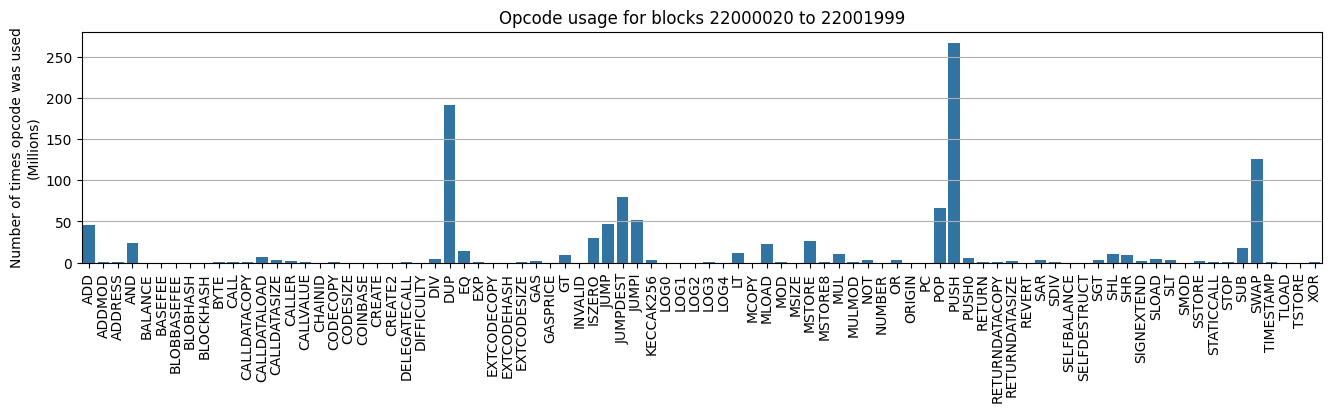

In [60]:
temp_df = (
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])]
    .groupby("op")["op_gas_pair_count"]
    .sum()
    .reset_index()
)
temp_df["op_gas_pair_count"] = temp_df["op_gas_pair_count"] / 1_000_000
plt.figure(figsize=(16, 3))
plt.grid()
sns.barplot(x="op", y="op_gas_pair_count", data=temp_df)
plt.xticks(rotation=90)
plt.title("Opcode usage for blocks 22000020 to 22001999")
plt.ylabel("Number of times opcode was used\n(Millions)")
plt.xlabel("")
plt.show()

In [ ]:
temp_df = (
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])]
    .groupby("op")["op_gas_pair_count"]
    .sum()
    .reset_index()
)
temp_df["op_gas_pair_count"] = temp_df["op_gas_pair_count"]
plt.figure(figsize=(16, 3))
plt.grid()
sns.barplot(x="op", y="op_gas_pair_count", data=temp_df)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Opcode usage for blocks 22000020 to 22001999")
plt.ylabel("Number of times opcode was used\n(log scale)")
plt.xlabel("")
plt.show()

### Opcode gas usage

In [ ]:
temp_df = (
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])]
    .groupby("op")["op_total_gas_cost"]
    .sum()
    .reset_index()
)
temp_df["op_total_gas_cost"] = temp_df["op_total_gas_cost"] / 1_000_000_000
plt.figure(figsize=(16, 3))
plt.grid()
sns.barplot(x="op", y="op_total_gas_cost", data=temp_df)
plt.xticks(rotation=90)
plt.title("Opcode usage for blocks 22000020 to 22001999")
plt.ylabel("Total units of gas used for opcode\n(Billions)")
plt.xlabel("")
plt.show()

In [ ]:
temp_df = (
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])]
    .groupby("op")["op_total_gas_cost"]
    .sum()
    .reset_index()
)
temp_df["op_total_gas_cost"] = temp_df["op_total_gas_cost"]
plt.figure(figsize=(16, 3))
plt.grid()
sns.barplot(x="op", y="op_total_gas_cost", data=temp_df)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Opcode usage for blocks 22000020 to 22001999")
plt.ylabel("Total units of gas used for opcode\n(log scale)")
plt.xlabel("")
plt.show()

### Opcode usage correlation

In [ ]:
temp_df = pd.pivot_table(
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])],
    values="op_gas_pair_count",
    index="tx_hash",
    columns="op",
    aggfunc="sum",
    fill_value=0.0,
)
corr_mat = temp_df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - usage count")
ax.tick_params(axis="x", labelsize=7)
ax.tick_params(axis="y", labelsize=7)
plt.tight_layout()
plt.show()

In [ ]:
temp_df = pd.pivot_table(
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])],
    values="op_total_gas_cost",
    index="tx_hash",
    columns="op",
    aggfunc="sum",
    fill_value=0.0,
)
corr_mat = temp_df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - gas used")
ax.tick_params(axis="x", labelsize=7)
ax.tick_params(axis="y", labelsize=7)
plt.show()

## 5. Opcode gas usage vs transaction gas usage

Next, we will compare the total gas cost of the transaction with the cost of all opcodes used in the transaction. There are four main components to consider:

1. The intrinsic cost of the transaction, which is a fixed value of 21000 gas units or 53000 gas units when the transaction is a contract creation.
2. The cost of the input data, which costs 4 gas units for each zero bytes and 16 gas units for each non-zero byte.
3. The cost of the opcodes, which is the sum of all opcodes used in the transaction.
4. The gas refunds applied at the end of the transaction, which reduces the total gas cost. These refunds are triggered when the transaction uses the `SSTORE` opcode to set a storage slot to zero.

We already have the input data cost computed, and we can add the opcode costs from our data. The intrinsic cost is trivial. So, the final piece we need to compute is the gas refund. For simplicity, we will assume that the gas refund will be the difference between the total gas used by the transaction and the remaining terms.


In [8]:
op_tx_df = (
    usage_df.groupby(["block_height", "tx_hash"])
    .agg(
        {
            "op_total_gas_cost": "sum",
            "tx_gas_cost": "first",
            "tx_input_data_gas_cost": "first",
            "is_contract_creation": "max",
        }
    )
    .reset_index()
)
op_tx_df.columns = [
    "block_height",
    "tx_hash",
    "op_gas_cost",
    "tx_gas_cost",
    "tx_input_data_cost",
    "is_contract_creation",
]
op_tx_df["tx_gas_refund_estimated"] = np.where(
    op_tx_df["is_contract_creation"]==1,
    op_tx_df["op_gas_cost"] + op_tx_df["tx_input_data_cost"] + 53000.0 - op_tx_df["tx_gas_cost"],
    op_tx_df["op_gas_cost"] + op_tx_df["tx_input_data_cost"] + 21000.0 - op_tx_df["tx_gas_cost"],
)
op_tx_df.head()

,block_height,tx_hash,op_gas_cost,tx_gas_cost,tx_input_data_cost,is_contract_creation,tx_gas_refund_estimated
0,22000020,0x029c1f067919e7ef9387862fa0624b98a2a3624ec581...,141594.0,160530,736,0,2800.0
1,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,51859.0,105495,2136,0,-30500.0
2,22000020,0x050ff26618ce1c10b47644ac628e3648e96c6b217d25...,0.0,21064,64,0,0.0
3,22000020,0x070584ade4418b6cffa46b54888d33a86f44f1359e78...,0.0,21000,0,0,0.0
4,22000020,0x0786a329bb718b8afc44465662b6546273eac1d6e728...,8130.0,24890,560,0,4800.0


Let's check the gas refunds.

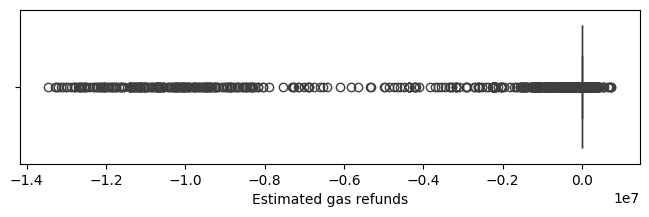

In [68]:
plt.figure(figsize=(8, 2))
sns.boxplot(data=op_tx_df, x="tx_gas_refund_estimated")
plt.xlabel("Estimated gas refunds")
plt.show()

In [63]:
sum(np.abs(op_tx_df["tx_gas_refund_estimated"]/op_tx_df["tx_gas_cost"])>0.2)/len(op_tx_df)

0.0652887719261748

Clearly, we have a problem - 6% of transactions have an estimated gas refund of more than 20% of the transaction gas cost, which is not allowed. Gas refunds are always capped by a fifth of the total gas cost. This means that we must have a problem with our opcode usage data.

Now, let's looks at the estimated gas refunds within the allowed bands.

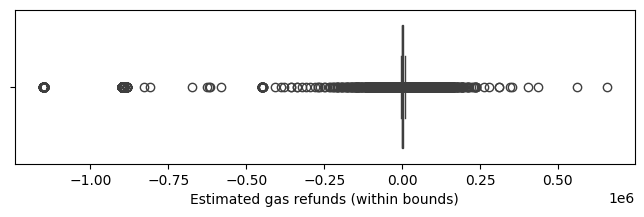

In [64]:
plt.figure(figsize=(8, 2))
sns.boxplot(
    data=op_tx_df[
        np.abs(op_tx_df["tx_gas_refund_estimated"] / op_tx_df["tx_gas_cost"]) < 0.2
    ],
    x="tx_gas_refund_estimated",
)
plt.xlabel("Estimated gas refunds (within bounds)")
plt.show()

We still have problems as the gas refunds should not be negative. We see 3.2% of such transactions. 

In [65]:
negative_refund_txs = op_tx_df[op_tx_df["tx_gas_refund_estimated"]<0]
negative_refund_tx_hashes = negative_refund_txs["tx_hash"].unique()
negative_refund_tx_op_df = usage_df[usage_df["tx_hash"].isin(negative_refund_tx_hashes)]

len(negative_refund_txs)/len(op_tx_df)

0.03200294024846487

In [66]:
t = negative_refund_tx_op_df["op"].unique()
t.sort()
t

array(['ADD', 'ADDMOD', 'ADDRESS', 'AND', 'BALANCE', 'BASEFEE',
       'BLOBBASEFEE', 'BLOBHASH', 'BLOCKHASH', 'BYTE', 'CALL',
       'CALLDATACOPY', 'CALLDATALOAD', 'CALLDATASIZE', 'CALLER',
       'CALLVALUE', 'CHAINID', 'CODECOPY', 'CODESIZE', 'COINBASE',
       'CREATE', 'CREATE2', 'DELEGATECALL', 'DIFFICULTY', 'DIV', 'DUP',
       'EQ', 'EXP', 'EXTCODECOPY', 'EXTCODEHASH', 'EXTCODESIZE', 'GAS',
       'GASPRICE', 'GT', 'INVALID', 'ISZERO', 'JUMP', 'JUMPDEST', 'JUMPI',
       'KECCAK256', 'LOG0', 'LOG1', 'LOG2', 'LOG3', 'LOG4', 'LT', 'MCOPY',
       'MLOAD', 'MOD', 'MSIZE', 'MSTORE', 'MSTORE8', 'MUL', 'MULMOD',
       'NOT', 'NUMBER', 'OR', 'ORIGIN', 'PC', 'POP', 'PUSH', 'PUSH0',
       'RETURN', 'RETURNDATACOPY', 'RETURNDATASIZE', 'REVERT', 'SAR',
       'SDIV', 'SELFBALANCE', 'SELFDESTRUCT', 'SGT', 'SHL', 'SHR',
       'SIGNEXTEND', 'SLOAD', 'SLT', 'SMOD', 'SSTORE', 'STATICCALL',
       'STOP', 'SUB', 'SWAP', 'TIMESTAMP', 'TLOAD', 'TSTORE', 'XOR'],
      dtype=object)

In [67]:
tx_with_issue_opcodes = len(
    negative_refund_tx_op_df[negative_refund_tx_op_df["op"].isin(["CREATE", "CREATE2", "DELEGATECALL","STATICCALL"])][
        "tx_hash"
    ].unique()
)
tx_with_issue_opcodes / len(negative_refund_tx_hashes)

0.9533044420368364

We still have issues in the opcode data collection as we clearly have some gas costs of opcodes that don't add up. We need to investigate further to understand why this is occurring.

For the meantime, we will ignore these transactions and simply assume they use 100% of the gas as compute.

In [70]:
negative_refund_txs

,block_height,tx_hash,op_gas_cost,tx_gas_cost,tx_input_data_cost,is_contract_creation,tx_gas_refund_estimated
1,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,51859.0,105495,2136,0,-30500.0
5,22000020,0x0c8d48db350d1120d9c467cf66cd38d3b054b74d247d...,40639.0,87355,416,0,-25300.0
51,22000020,0x74b71fbc1654dfc4cf9cc54ee3e5d958a1838d86173f...,607065.0,13943545,991480,0,-12324000.0
67,22000020,0xa42f78bdd54ed82d871230ae3294de3a4745894dc4ab...,47440.0,116656,1016,0,-47200.0
97,22000020,0xfcd1d61830478a60fd6d1f812c8d476705111081d2a5...,122099.0,213731,2032,0,-68600.0
...,...,...,...,...,...,...,...
288142,22001999,0x4b8cff998759465f4ec3db78c34efeeea14dab1b464e...,526820.0,728356,18236,0,-162300.0
288195,22001999,0x6a3c1cac2d11d90b14024ffc1fb790620e9242f471d8...,85289.0,143501,3912,0,-33300.0
288214,22001999,0x73e11135f94d15ce31d79ea4954f0eca2bbd09effbff...,177443.0,337907,25464,0,-114000.0
288304,22001999,0xae7f8f00b44ccbf72a9d8ae3a62f087a22cd7004e01e...,67309.0,97893,584,0,-9000.0


In [11]:
temp_df = usage_df[usage_df["tx_hash"]=="0x0395c4139f9b563fe264651b47699842a6fdaf704cbea7a58c2ddccb7ec4ea88"]
temp_df[temp_df["op"]=="DELEGATECALL"]


,block_height,tx_hash,op,op_gas_cost,op_gas_pair_count,tx_gas_cost,tx_input_data_gas_cost,is_contract_creation,op_total_gas_cost
10916,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,DELEGATECALL,100.0,1,105495,2136,0,100.0


In [14]:
usage_df[usage_df["tx_hash"]=="0x0395c4139f9b563fe264651b47699842a6fdaf704cbea7a58c2ddccb7ec4ea88"]

,block_height,tx_hash,op,op_gas_cost,op_gas_pair_count,tx_gas_cost,tx_input_data_gas_cost,is_contract_creation,op_total_gas_cost
27,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,MSTORE,12.0,8,105495,2136,0,96.0
28,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,CALLDATASIZE,2.0,9,105495,2136,0,18.0
29,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,DUP,3.0,270,105495,2136,0,810.0
30,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,DUP,3.0,273,105495,2136,0,819.0
31,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,DUP,3.0,36,105495,2136,0,108.0
...,...,...,...,...,...,...,...,...,...
16304,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,EXTCODESIZE,100.0,1,105495,2136,0,100.0
16305,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,MSTORE8,3.0,1,105495,2136,0,3.0
16306,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,CODECOPY,6.0,1,105495,2136,0,6.0
16307,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,STOP,0.0,1,105495,2136,0,0.0
